# Self Distillation rebuilt

## A new from the ground attempt at self distillation to try to sort out some of the issues that we faced in previous builds and testing.

## A new notebook for a new year.
---
## Primary issues
The main problems faced previously were to do with establishing a baseline of performance of a model to compare the self distilation work against. 


---


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp

os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [2]:
from tensorflow.keras import layers, models

def summarize_keras_trainable_variables(model, message):
    s = sum(map(lambda x: x.sum(), model.get_weights()))
    print("summary of trainable variables %s: %.13f" % (message, s))
    return s


In [3]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=False)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [4]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [5]:

class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = 0
        if epoch >= self.starting_epoch:
            val = tf.reduce_min([self.max_t, tf.cast((epoch - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)
        
class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
#     def on_training_end(self, logs={}):
#         ''' indicate that training has ended, so turn off val growth. Not sure if this is actually needed...
#         '''
#         tf.print("training commenced, validation growth enabled")
#         self.training.assign(False)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch-1:
            tf.print(self.step)
            if self.val_acc >= self.past_val_acc:
                self.step.assign(self.step + 1)
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                # self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
        else:
            self.step.assign(self.step + 1)
            tf.print("annealing coef will start on epoch:", self.starting_epoch)
     # tf.print("past val acc =", self.past_val_acc)
        # self.past_val_acc.assign(self.val_acc)
        
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('branch_exit_1_accuracy')+ logs.get('branch_exit_accuracy'))  

In [6]:

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl


def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)



def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    # alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    alpha = tf.nn.softplus(logits)
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost




In [7]:

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output


    
class SelfDistilDense(branches.branch.BranchEndpoint):
        def __init__(self, num_outputs, loss_coef=.3, temperature=10, name=None, **kwargs):
            super(SelfDistilDense, self).__init__(num_outputs=num_outputs, name=name)
            self.num_outputs = num_outputs
            self.loss_coef = loss_coef
            self.temperature = temperature 
            self.distillation_loss_fn=keras.losses.KLDivergence()

        def build(self, input_shape):
            tf.print("inputShape",input_shape)
            # self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'name': self.name
            })
            return config

        def call(self, inputs, teaching_distill=None):
            ''' do the normal kernel operations, then compare the difference between the teacher and this.
            '''
            # outputs = tf.matmul(inputs,self.kernel)
            # outputs = tf.nn.relu(outputs)
            # tf.print("outputs",outputs)
            # tf.print("teaching",teaching_distill)
            if teaching_distill is not None:
                distil_loss = self.distillation_loss_fn(inputs/self.temperature, teaching_distill/self.temperature)
                distil_loss = distil_loss * self.loss_coef
                # print("KL_LOSS", kl_loss)
                # self.add_loss(kl_loss)
                self.add_loss(distil_loss)
                self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
            return inputs
        
class SelfDistilEndpoint_2(branches.branch.BranchEndpoint):
        def __init__(self, num_outputs, loss_coef=1.9, temperature=10, name=None, **kwargs):
            super(SelfDistilEndpoint_2, self).__init__(num_outputs=num_outputs, name=name)
            self.num_outputs = num_outputs
            self.loss_coef = loss_coef
            self.temperature = temperature 
            self.distillation_loss_fn=keras.losses.KLDivergence()

        def build(self, input_shape):
            tf.print("inputShape",input_shape)
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'name': self.name
            })
            return config

        def call(self, inputs, teaching_distill=None):
            ''' do the normal kernel operations, then compare the difference between the teacher and this.
            '''
            outputs = tf.matmul(inputs,self.kernel)
            outputs_sm = tf.nn.softmax(outputs)
            # tf.print("outputs",outputs)
            # tf.print("teaching",teaching_distill)
            if teaching_distill is not None:
                distil_loss = self.distillation_loss_fn(outputs_sm/self.temperature, teaching_distill/self.temperature)
                distil_loss = distil_loss * self.loss_coef
                # print("KL_LOSS", kl_loss)
                # self.add_loss(kl_loss)
                self.add_loss(distil_loss)
                self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
            return outputs

class distillBranch():
    def __init__(self, _teacher, _features, loss_coef=1.0, temperature = 10,**kwargs):
        self.loss_coef = loss_coef
        self.temperature = temperature
        self.teacher = _teacher
        self.features = _features
    def _branch_feature_distill(self,prevLayer, targets=None, teacher = None, teaching_features=None):
        """ Add a new branch to a model connecting at the output of prevLayer. 
            NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
        """ 
    #     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    #     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
    #     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
    #     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
        branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
        branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
        branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
        branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
        branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
        # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
        branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
        branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
        branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
        # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
        branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
        branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
        branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
        branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
        branchLayer = SelfDistilDense(512, loss_coef=self.loss_coef, temperature = self.temperature, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,self.features)
        # tf.print(branchLayer)
        # branchLayer = layers.ReLU()(branchLayer)
        output = SelfDistilEndpoint_2(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,self.teacher)
        # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
        # output = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
        return output

    
def _branch_conv2_distill(prevLayer, targets=None, teacher = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = SelfDistilDense(512, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,teacher)
    # branchLayer = layers.ReLU()(branchLayer)
    # print(teacher)
    output = SelfDistilEndpoint_2(num_outputs=10, loss_coef=1.3, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,teacher)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    # output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output




In [9]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()


# model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')
# lambda_callback = lambda_update(10,0,max_t = .5, starting_epoch =1)
  
def EDL_Loss(lambda_callback: lambda_update):
    def custom_loss_function(labels, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # tf.print(logits,logits.shape)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        loss = (A+B)
        # p = 6
        # prob_c  = evidence * labels
        # ic_mask = tf.cast(1 - labels,tf.float32)
        # _A = (1-tf.reduce_sum(prob_c,axis=1)) ** p
        # _B = tf.reduce_sum((ic_mask * evidence) ** p, axis=1)
        # loss = annealing_coef * ((_A + _B) ** (1/p))
        # bool_mask = tf.cast(labels,tf.bool)
        # ic_mask = tf.cast(1 - labels,tf.bool)
        # ic_bool_mask = tf.cast(ic_mask,tf.bool)
        # ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        # #### info reg
        # _A = tf.reduce_sum((ic_alpha_masked -1) ** 2,axis=1,keepdims=True)
        # B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        # B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        # # tf.print(_A.shape,summarize=-1)
        # _B = (B_1 - B_2)
        # # tf.print(_B,summarize=-1)
        # info_reg =  .5* (_A * _B)
        # info_reg = annealing_coef * info_reg
        
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        
        return (loss) + D #info_reg + D #+alp #+ C +  D  #+ info_reg #+ C + D
    return custom_loss_function


def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        # evidence = exp_evidence(logits)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



def IAD_loss(lambda_callback: lambda_update):
    crossEntropy = keras.losses.CategoricalCrossentropy(from_logits=False)
    def custom_loss_function(labels, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # tf.print(logits,logits.shape)
        # evidence = tf.nn.softplus(logits)
        
        # loss = crossEntropy(labels,evidence)
        
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        # tf.print("m",m,summarize=-1)
        p = 6
        prob_c  = m * labels
        ic_mask = tf.cast(1 - labels,tf.float32)
        _A = (1-tf.reduce_sum(prob_c,axis=1)) ** p
        # tf.print("_A",_A)
        _B = tf.reduce_sum((ic_mask * m) ** p, axis=1)
        # tf.print("_b",_B,summarize=-1)
        loss = ((_A + _B) ** (1/p))
        
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # C =   annealing_coef * (A+B)
         #### info reg
            
        ic_mask = tf.cast(1 - labels,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)

        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        
        #sum of icAlpha -1 squared
        A_ = ((ic_alpha_masked -1) ** 2)
        #polygamma1 of icAlpha - polygamma1 of sum of alpha
        
        
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        # print(B_1)
        # print(B_2)
        B_ = (B_1 - B_2)
        info_reg = .5 * tf.reduce_sum((A_ * B_),axis=1)
        # tf.print(tf.reduce_mean(info_reg,axis=1),summarize=-1)
        info_reg = annealing_coef * info_reg
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # if annealing_coef>0:
            # tf.print("loss",loss,summarize=-1)
            # tf.print("info",info_reg,summarize=-1)
            
        return (loss) + info_reg + D #+alp #+ C +  D  #+ info_reg #+ C + D
        # return (loss) + (A+B) + D #+alp #+ C +  D  #+ info_reg #+ C + D
    return custom_loss_function



growth_callback = growth_update(60, 0.,max_t = 1, starting_epoch =1)
# auxlossMetric = auxLoss(growth_callback)
branch_loss = EDL_Loss(growth_callback)
# branch_loss_CE = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# def scheduler(epoch,lr):
#     if epoch < 5:
#         tf.print("learning rate set to",lr)
#         return lr
#     else:
#         modif = 1+ (epoch % 5) /10
#         tf.print("learning rate set to",lr * modif)
#         return lr  * modif
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    

model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

# model.add_branches([_branch_conv2,_branch_conv2],
#                           ["conv2_block1_out","conv2_block3_out",
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

print(model.layers[-2])
dBranch = distillBranch(model.layers[-1].output,model.layers[-2].output,loss_coef = 0.1, temperature = 30)

print(dBranch._branch_feature_distill)
model.add_distill("classification",[dBranch._branch_feature_distill,dBranch._branch_feature_distill],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          loop=False,num_outputs=10)


# model.add_distill("classification",[_branch_conv2_distill,_branch_conv2_distill],
#                           ["conv2_block1_out","conv2_block3_out",
#                           ],
#                           loop=False,num_outputs=10)

model.setTrainable(True)

# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,CE_loss,CE_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
#                   optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
#                   # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
#                   # optimizer="adam",
#                metrics=['accuracy'])



<bound method distillBranch._branch_feature_distill of <__main__.distillBranch object at 0x000001CC149B1D48>>
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
inputShape TensorShape([None, 512])
inputShape TensorShape([None, 512])
add Branch to branch point  conv2_block3_out
inputShape TensorShape([None, 512])
inputShape TensorShape([None, 512])
branch added <keras.engine.functional.Functional object at 0x000001CC3F072408>
Freezing Main Layers and setting branch layers training to true


In [10]:

# model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# print(model.layers[-1])
# print(model.layers.pop(-1))
# print(model.layers[-1])

In [11]:
#distil, sgd sm + features 
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 59s 34ms/step - loss: 4.5940 - classification_loss: 0.1499 - branch_exit_loss: 1.4510 - branch_exit_1_loss: 1.3828 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.4794 - branch_exit_1_accuracy: 0.5073 - branch_feature_student_distil: 0.1263 - branch_feature_student_1_distil: 0.1380 - branch_exit_distil: 0.6927 - branch_exit_1_distil: 0.6529 - val_loss: 3.9278 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.2017 - val_branch_exit_1_loss: 1.0797 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.5794 - val_branch_exit_1_accuracy: 0.6534 - val_branch_feature_student_distil: 0.0732 - val_branch_feature_student_1_distil: 0.0690 - val_branch_exit_distil: 0.4233 - val_branch_exit_1_distil: 0.3105
Epoch 2/3
1407/1407 [==============================] - 46s 33ms/step - loss: 3.1014 - classification_loss: 0.1499 - branch_exit_loss: 1.1398 - branch

In [145]:
#distil, sgd sm + features 
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 53s 34ms/step - loss: 4.6638 - classification_loss: 0.1499 - branch_exit_loss: 1.4750 - branch_exit_1_loss: 1.3982 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.4694 - branch_exit_1_accuracy: 0.4999 - branch_feature_student_distil: 0.1038 - branch_feature_student_1_distil: 0.1675 - branch_exit_distil: 0.7040 - branch_exit_1_distil: 0.6650 - val_loss: 4.0643 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.2350 - val_branch_exit_1_loss: 1.1357 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.5894 - val_branch_exit_1_accuracy: 0.6344 - val_branch_feature_student_distil: 0.0509 - val_branch_feature_student_1_distil: 0.0931 - val_branch_exit_distil: 0.4521 - val_branch_exit_1_distil: 0.3270
Epoch 2/3
1407/1407 [==============================] - 45s 32ms/step - loss: 3.1192 - classification_loss: 0.1499 - branch_exit_loss: 1.1263 - branch

In [131]:
#distil, sgd
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 47s 30ms/step - loss: 3.5386 - classification_loss: 0.1499 - branch_feature_student_loss: 1.2870 - branch_feature_student_1_loss: 1.1000 - classification_accuracy: 0.9525 - branch_feature_student_accuracy: 0.5606 - branch_feature_student_1_accuracy: 0.6334 - branch_feature_student_distil: 0.5592 - branch_feature_student_1_distil: 0.4421 - val_loss: 3.3615 - val_classification_loss: 0.7682 - val_branch_feature_student_loss: 1.0927 - val_branch_feature_student_1_loss: 0.9039 - val_classification_accuracy: 0.7874 - val_branch_feature_student_accuracy: 0.6264 - val_branch_feature_student_1_accuracy: 0.7016 - val_branch_feature_student_distil: 0.3569 - val_branch_feature_student_1_distil: 0.2381
Epoch 2/3
1407/1407 [==============================] - 39s 28ms/step - loss: 2.6696 - classification_loss: 0.1499 - branch_feature_student_loss: 1.0215 - branch_feature_student_1_loss: 0.81

In [133]:
#no distill, sgd
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 42s 27ms/step - loss: 2.4721 - classification_loss: 0.1499 - branch_exit_loss: 1.2539 - branch_exit_1_loss: 1.0683 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5565 - branch_exit_1_accuracy: 0.6318 - val_loss: 2.7930 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.0527 - val_branch_exit_1_loss: 0.9721 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.6270 - val_branch_exit_1_accuracy: 0.6698
Epoch 2/3
1407/1407 [==============================] - 37s 26ms/step - loss: 1.9426 - classification_loss: 0.1499 - branch_exit_loss: 0.9946 - branch_exit_1_loss: 0.7981 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6533 - branch_exit_1_accuracy: 0.7298 - val_loss: 2.7129 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.0252 - val_branch_exit_1_loss: 0.9194 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy

In [129]:
#distil, adam
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 45s 29ms/step - loss: 3.4366 - classification_loss: 0.1499 - branch_feature_student_loss: 1.2458 - branch_feature_student_1_loss: 1.0673 - classification_accuracy: 0.9525 - branch_feature_student_accuracy: 0.5723 - branch_feature_student_1_accuracy: 0.6394 - branch_feature_student_distil: 0.5427 - branch_feature_student_1_distil: 0.4307 - val_loss: 3.4621 - val_classification_loss: 0.7682 - val_branch_feature_student_loss: 1.1705 - val_branch_feature_student_1_loss: 0.9338 - val_classification_accuracy: 0.7874 - val_branch_feature_student_accuracy: 0.5982 - val_branch_feature_student_1_accuracy: 0.6870 - val_branch_feature_student_distil: 0.3523 - val_branch_feature_student_1_distil: 0.2354
Epoch 2/3
1407/1407 [==============================] - 40s 28ms/step - loss: 2.5507 - classification_loss: 0.1499 - branch_feature_student_loss: 0.9663 - branch_feature_student_1_loss: 0.78

In [125]:
#### CE no distil adam
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 42s 27ms/step - loss: 2.4556 - classification_loss: 0.1499 - branch_exit_loss: 1.2392 - branch_exit_1_loss: 1.0665 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5608 - branch_exit_1_accuracy: 0.6322 - val_loss: 2.7918 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.1477 - val_branch_exit_1_loss: 0.8758 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.5982 - val_branch_exit_1_accuracy: 0.6966
Epoch 2/3
1407/1407 [==============================] - 38s 27ms/step - loss: 1.9078 - classification_loss: 0.1499 - branch_exit_loss: 0.9683 - branch_exit_1_loss: 0.7895 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6603 - branch_exit_1_accuracy: 0.7289 - val_loss: 2.5399 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.9531 - val_branch_exit_1_loss: 0.8186 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy

In [ ]:
model.save("models/journal_models/resnetDistil_edl_sm.hdf5")

In [40]:
#distill
model.fit(train_ds, validation_data=validation_ds, epochs=15)

Setting Main Layers  and branch layers training to true
Epoch 1/15
1407/1407 [==============================] - 56s 36ms/step - loss: 3.1156 - classification_loss: 0.1499 - branch_exit_loss: 0.9400 - branch_exit_1_loss: 0.9393 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5090 - branch_exit_1_accuracy: 0.5793 - branch_exit_distil: 0.5989 - branch_exit_1_distil: 0.4875 - val_loss: 3.3676 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.9394 - val_branch_exit_1_loss: 0.9383 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.5638 - val_branch_exit_1_accuracy: 0.6636 - val_branch_exit_distil: 0.4377 - val_branch_exit_1_distil: 0.2813
Epoch 2/15
1407/1407 [==============================] - 48s 34ms/step - loss: 2.7461 - classification_loss: 0.1499 - branch_exit_loss: 0.9389 - branch_exit_1_loss: 0.9381 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6158 - branch_exit_1_accuracy: 0.6955 - branch_exit_distil: 0.4186 - branch_exit_1_distil

In [41]:
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 48s 30ms/step - loss: 3.5128 - classification_loss: 0.1499 - branch_exit_loss: 1.2834 - branch_exit_1_loss: 1.0840 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5596 - branch_exit_1_accuracy: 0.6376 - branch_exit_distil: 0.5611 - branch_exit_1_distil: 0.4346 - val_loss: 3.3337 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.0758 - val_branch_exit_1_loss: 0.8675 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.6308 - val_branch_exit_1_accuracy: 0.7136 - val_branch_exit_distil: 0.3731 - val_branch_exit_1_distil: 0.2476
Epoch 2/3
1407/1407 [==============================] - 40s 28ms/step - loss: 2.6531 - classification_loss: 0.1499 - branch_exit_loss: 1.0102 - branch_exit_1_loss: 0.8161 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6616 - branch_exit_1_accuracy: 0.7319 - branch_exit_distil: 0.3943 - branch_exit_1_distil: 

In [9]:

# temp 10, equal weighting of loss 
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 50s 30ms/step - loss: 3.0219 - classification_loss: 0.1499 - branch_exit_loss: 1.2653 - branch_exit_1_loss: 1.0697 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5608 - branch_exit_1_accuracy: 0.6365 - branch_exit_distil: 0.3021 - branch_exit_1_distil: 0.2348 - val_loss: 2.9836 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.0463 - val_branch_exit_1_loss: 0.8442 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.6388 - val_branch_exit_1_accuracy: 0.7168 - val_branch_exit_distil: 0.1967 - val_branch_exit_1_distil: 0.1275
Epoch 2/3
1407/1407 [==============================] - 40s 29ms/step - loss: 2.3202 - classification_loss: 0.1499 - branch_exit_loss: 0.9966 - branch_exit_1_loss: 0.8053 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6584 - branch_exit_1_accuracy: 0.7301 - branch_exit_distil: 0.2136 - branch_exit_1_distil: 

In [16]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()


growth_callback = growth_update(60, 0.,max_t = 1, starting_epoch =1)
# auxlossMetric = auxLoss(growth_callback)
branch_loss = IAD_loss(growth_callback)
# branch_loss_CE = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# def scheduler(epoch,lr):
#     if epoch < 5:
#         tf.print("learning rate set to",lr)
#         return lr
#     else:
#         modif = 1+ (epoch % 5) /10
#         tf.print("learning rate set to",lr * modif)
#         return lr  * modif
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    

model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

# model.add_branches([_branch_conv2_distill,_branch_conv2_distill],
#                           ["conv2_block1_out","conv2_block3_out",
#                           ],
#                           target_input=False,loop=False,num_outputs=10)
# model.summary()
model.add_distill("classification",[_branch_conv2_SM,_branch_conv2_SM],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          loop=False,num_outputs=10)

model.setTrainable(True)

# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,trunk_loss,trunk_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])




Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
branch added <keras.engine.functional.Functional object at 0x000002040A14BBC8>
Freezing Main Layers and setting branch layers training to true


In [17]:
model.fit(train_ds, validation_data=validation_ds, epochs=3)

Setting Main Layers  and branch layers training to true
Epoch 1/3
1407/1407 [==============================] - 42s 27ms/step - loss: 2.4771 - classification_loss: 0.1499 - branch_exit_loss: 1.2667 - branch_exit_1_loss: 1.0605 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5513 - branch_exit_1_accuracy: 0.6324 - val_loss: 2.6069 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.9988 - val_branch_exit_1_loss: 0.8398 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.6596 - val_branch_exit_1_accuracy: 0.7184
Epoch 2/3
1407/1407 [==============================] - 37s 26ms/step - loss: 1.9521 - classification_loss: 0.1499 - branch_exit_loss: 1.0006 - branch_exit_1_loss: 0.8016 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6502 - branch_exit_1_accuracy: 0.7282 - val_loss: 2.4577 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.9210 - val_branch_exit_1_loss: 0.7684 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy

In [41]:
from scipy.special import logsumexp

def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10):
    '''
        Function for collecting the model's predictions on a test set. 

        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
                # evidence =tf.nn.softplus(prediction)
                # alpha = evidence +1
                # S = sum(alpha)
                # E = alpha - 1
                # Mass = alpha / S
                # u = num_classes / S
                # Uncert[k].append(u.numpy().mean())
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                Energy[k].append( -(logsumexp(np.array(prediction))))
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                # # calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                # dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                # entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],
                           # "uncert":Uncert[j],
                            "energy":Energy[j],
                            # 'entropy':Entropy[j],
                            # # 'calibration':calibration[j],
                            # "confidence_alea_uncert":conf[j],
                            # "entropy_of_expected":entropy_of_exp[j],
                            # "expected_entropy":expected_entropy[j],
                            # "mutual_information":mutual_info[j],
                            # "EPKL":epkl[j],
                            # "differential_entropy":dentropy[j],
                          })
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [34]:
# model = tf.keras.models.load_model("./models/journal_models/resnet_CE_15_.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"growth_callback":growth_callback,"custom_loss_function":branch_loss})


In [42]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3


In [43]:
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3


In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            if exit > 0: #if a specific exit number is specified, only output the results of that exit.
                _ID = [_ID[max(exit-1,0)]]
                _OOD = [_OOD[max(exit-1,0)]]
                exit_labels=['exit_{}'.format(exit)]

            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
             
                
                if threshold:
                    if type(threshold) is list:
                        if i >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[i]
                        print("threshold",_threshold)
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        # print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
  
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


metric:  energy threshold:  gmean


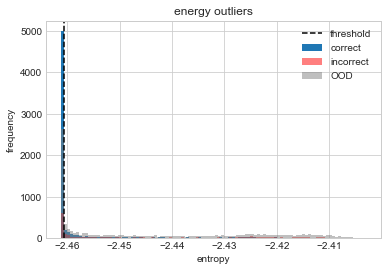

['exit_1', 'exit_2']


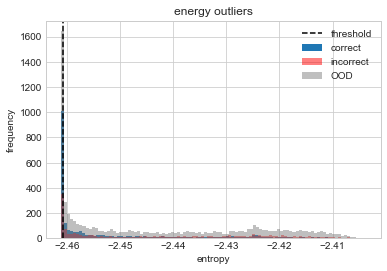

['exit_1', 'exit_2']


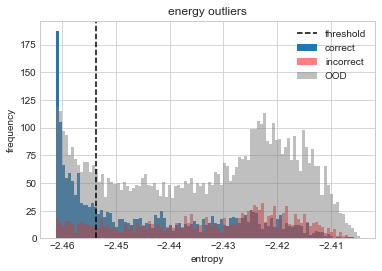

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7263 -2.460601         5577          2613              4977           0.680952             0.607692
1     exit_2       4423        7387         0.7390  -2.46089         1194          1388               898           0.462432             0.347792
2  Main_exit       3229        5999         0.7815        NA         3229          5999              1906           0.349913             0.206545


In [44]:
#distill branches loss_coef 1.9 temp 10 sgd, edl
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


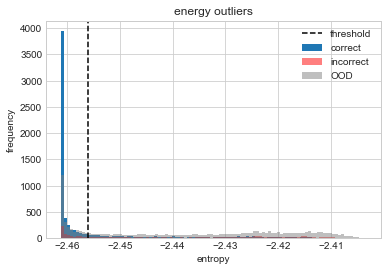

['exit_1', 'exit_2']


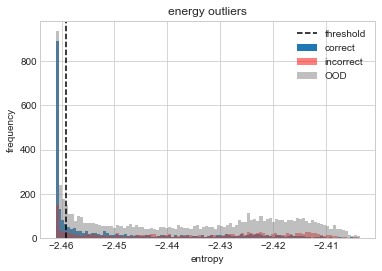

['exit_1', 'exit_2']


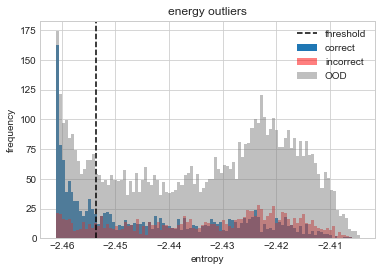

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7445 -2.456015         5845          2570              5286           0.694593             0.628164
1     exit_2       4155        7430         0.7703 -2.459212         1366          1411              1143           0.491898             0.411595
2  Main_exit       2789        6019         0.7815        NA         2789          6019              1547           0.316644             0.175636


In [33]:
#distill branches loss_coef 1.9 temp 10 old adam
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

In [38]:
#no distill branches adam CE
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7446   3.21823         5724          2424              5219           0.702504             0.640525
1     exit_2       4276        7576         0.7774  3.235315         1645          1688              1393           0.493549             0.417942
2  Main_exit       2631        5888         0.7861        NA         2631          5888              1390           0.308839             0.163165
metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7446  -2.46002         5724          2424              5219           0

metric:  energy threshold:  gmean


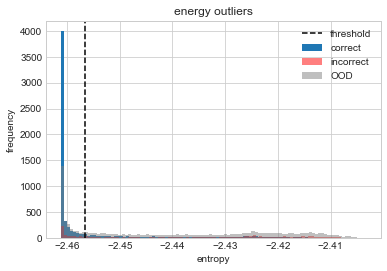

['exit_1']


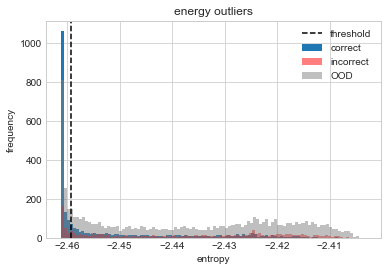

['exit_1', 'exit_2']


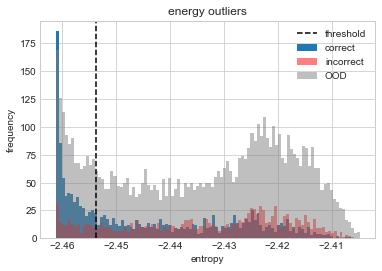

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7340 -2.456647         5628          2685              5096           0.677012             0.613016
1     exit_2       4372        7315         0.7776 -2.459178         1595          1288              1334           0.553243             0.462712
2  Main_exit       2777        6027         0.7815        NA         2777          6027              1552           0.315425             0.176284


In [28]:
#distill branches loss_coef 1.9 temp 10 SGD
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


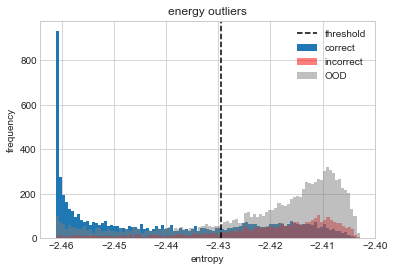

['exit_1']


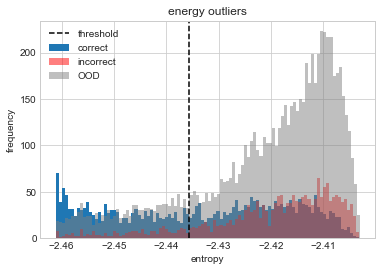

['exit_1', 'exit_2']


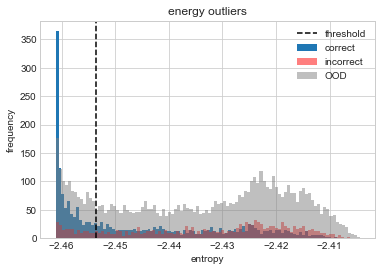

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6753 -2.429404         5138          2459              4406           0.676320             0.579966
1     exit_2       4862        7541         0.7310 -2.435719         1519          1270              1252           0.544640             0.448906
2  Main_exit       3343        6271         0.7815        NA         3343          6271              2020           0.347722             0.210110


In [26]:
#standard branches CE Frozen  coef0.3
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

In [26]:
#updated distillation, loss_coef = 1.9,  temp 5
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6904 -2.433489         5496          2824              4768           0.660577             0.573077
1     exit_2       4504        7176         0.7442 -2.441773         1527          1367              1211           0.527643             0.418452
2  Main_exit       2977        5809         0.7815        NA         2977          5809              1772           0.338835             0.201684


In [32]:
#updated distillation, loss_coef = 1.9,  temp 20
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6708 -2.428008         5674          2742              4699           0.674192             0.558341
1     exit_2       4326        7258         0.7217 -2.432864         1454          1313              1159           0.525479             0.418865
2  Main_exit       2872        5945         0.7815        NA         2872          5945              1717           0.325734             0.194737


In [38]:
#updated distillation, loss_coef = 1.9,  temp 10
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6997 -2.432136         5617          2687              4897           0.676421             0.589716
1     exit_2       4383        7313         0.7460 -2.438999         1457          1253              1199           0.537638             0.442435
2  Main_exit       2926        6060         0.7815        NA         2926          6060              1703           0.325618             0.189517


In [44]:
#updated distillation, loss_coef = 1.9,  temp 10
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6764  -2.43471         5281          2194              4574           0.706488             0.611906
1     exit_2       4719        7806         0.7246 -2.435542         1625          1521              1243           0.516529             0.395105
2  Main_exit       3094        6285         0.7815        NA         3094          6285              1853           0.329886             0.197569


metric:  energy threshold:  gmean


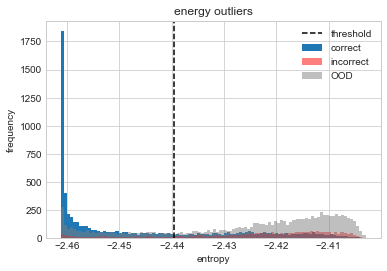

['exit_1']


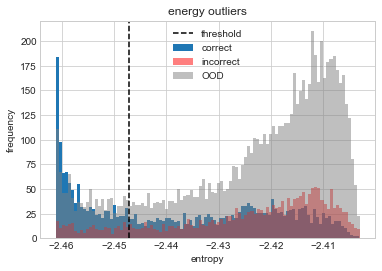

['exit_1', 'exit_2']


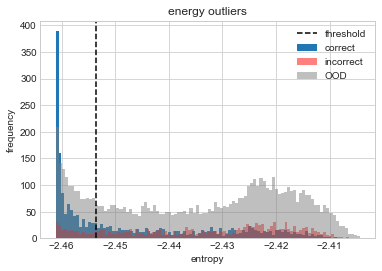

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7086 -2.439569         5308          2284              4748           0.699157             0.625395
1     exit_2       4692        7716         0.7348 -2.447171         1294          1023              1045           0.558481             0.451014
2  Main_exit       3398        6693         0.7815        NA         3398          6693              2052           0.336736             0.203350


In [19]:
#updated distillation
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


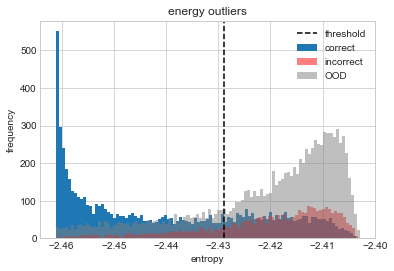

['exit_1', 'exit_2']


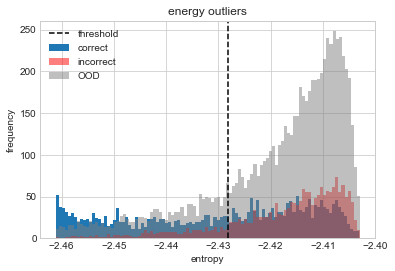

['exit_1', 'exit_2']


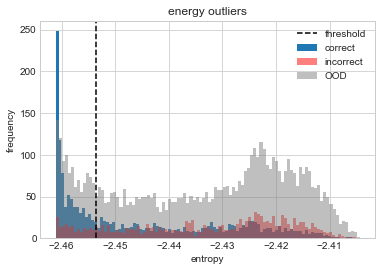

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6813 -2.428888         5351          2464              4634           0.684709             0.592962
1     exit_2       4649        7536         0.7323 -2.428144         1598          1553              1289           0.507141             0.409076
2  Main_exit       3051        5983         0.7815        NA         3051          5983              1755           0.337724             0.194266


In [31]:
#self distil branches CE Frozen coef0.3
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)